# K-Nearest-Neigbors MNIST Classification

---

## Table of Contents
1. KNN Explained
2. Library used for Optimized Nearest Neighbor Search
3. Basic from Scratch Implimentation
4. Visualization
5. Library Optimized Implimentation
6. Comparison and Final Words

<br />

---

## KNN Explained

K-Nearest-Neighbors (KNN)

<br />

---

## Optimization with Faiss & Annoy

Pl

<br />

---

## Basic from Scratch Implimenation


In [4]:
# IMPORTS

import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from mlxtend.data import loadlocal_mnist
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.evaluate import confusion_matrix

# Optimization Libraries
from annoy import AnnoyIndex
import faiss


In [24]:
# Compile MNIST Dataset

X, y = loadlocal_mnist(images_path='./mnist_data/train-images-idx3-ubyte', labels_path='./mnist_data/train-labels-idx1-ubyte')

train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size = 0.2)


# Heavily processed mnist data for basic implimentation 
# SIZE (1797, 64)
mnist = load_digits()

# Splitting into training and testing
small_train_data, small_test_data, small_train_labels, small_test_labels = train_test_split(mnist.data, mnist.target, test_size=0.2)


In [25]:
# Basic Intuitive from Scratch Implimentation

# Accury and Speed not the best
# But more intuitive than either
# FaissKNeighbors or AnnoyKNN
class KNN:
    def __init__(self, K):
        self.K = K

    def _distance(self, x, z):
        return np.linalg.norm(x - z, axis = 1)

    def fit(self, X_train, y_train):
        """
        Because all computation is done during predict, nothing
        is needed here.

        """
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        self.X_test = X_test

        m, n = np.shape(X_test)
        predictions = np.zeros(m)

        for i in range(m):
            distance = self._distance(self.X_test[i], self.X_train)

            index = np.argsort(distance, axis = 0, kind="heapsort")[: self.K]

            predictions[i] = np.argmax(np.bincount(self.y_train[index]))

        return predictions
    
    def accuracy_score(self, predictions, actual):
        num_predictions = len(predictions)
        
        predictions[predictions != actual] = 0
        predictions[predictions == actual] = 1

        num_correct = np.sum(predictions)

        accuracy = float(num_correct) / num_predictions
        
        print("Number of Predictions: {} | Accurary: {}".format(num_predictions, accuracy))
    

In [26]:
model = KNN(K = 3)
model.fit(small_train_data, small_train_labels)
predictions = model.predict(small_test_data)
model.accuracy_score(predictions, small_test_labels)

Number of Predictions: 360 | Accurary: 0.9944444444444445


## Analysis of Basic Implimentation

This version when working with heavily compiled mnist data works well. Though computing the L2 norm is extremely expensive and time consuming. To run this on the vanilla MNIST dataset would take days and the accuracy (for some unknown reason) is only about 80%.

And so we optimize. I found an article (will link under this text) that indroduced me to a library that was built for computing the nearest neighbors. This library was called Faiss which lead me down a further hole into a whole world of libraries built for solving this nearest neighbor problem. This lead me to the library Annoy which I will use to optimize my implimentation.

<br />

---

## Annoy Implimentation


In [27]:
class AnnoyKNN:
    def __init__(self, K = 3):
        self.K = K

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.m, self.n = np.shape(X_train)

    def predict(self, X_test):
        test_m, test_n = np.shape(X_test)

        # Initializes Annoy index / matrix
        matrix = AnnoyIndex(self.n, 'euclidean')

        # Constructing Annoy matrix
        for i in range(self.m):
            matrix.add_item(i, self.X_train[i])

        # Builds Annoy matrix
        matrix.build(self.K)

        # Building prediction matrix
        predictions = np.zeros(test_m)


        for i in range(test_m):
            # Compiles k nearest neighbors for each number / data point
            # in out testing data and returns their index
            index = matrix.get_nns_by_vector(X_test[i], self.K)

            # Given our indexes above, this is piece of code "votes"
            # and returns the majority nearest neighbor
            predictions[i] = np.argmax(np.bincount(self.y_train[index]))

        return predictions
    
    def accuracy_score(self, predictions, actual):
        num_predictions = len(predictions)
        
        predictions[predictions != actual] = 0
        predictions[predictions == actual] = 1

        num_correct = np.sum(predictions)

        accuracy = float(num_correct) / num_predictions
        
        print("Number of Predictions: {} | Accurary: {}".format(num_predictions, accuracy))
        
        

In [39]:
# Training on the entire vanilla MNIST dataset only takes about 15 second! 

model = AnnoyKNN(K = 3)
model.fit(train_data, train_labels)
predictions = model.predict(test_data)

# Computing confusion matrix for next slide
cm = confusion_matrix(y_target=test_labels, y_predicted=predictions, binary=False)

model.accuracy_score(predictions, test_labels)

Number of Predictions: 12000 | Accurary: 0.95275


## Analysis of Annoy Implimentation

This implimentation is exponentially quicker saving me literally hours and hours of compute time. The accuracy is also quite impressive. Plotting a confusion matrix to get more detail about this:

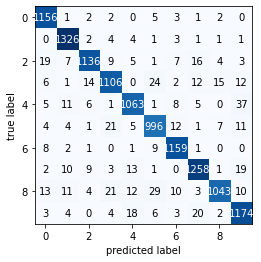

In [41]:
# Plotting confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=cm)